In [21]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad

## **1. Lewis (2001) Approach**

Let's start by revisiting the Fourier methods for pricing in the Merton (1976) model. Essentially, under the Lewis (2001) approach, the value of the Call option is determined by:

$$
\begin{equation*}
    C_0 = S_0 - \frac{\sqrt{S_0 K} e^{-rT}}{\pi} \int_{0}^{\infty} \mathbf{Re}[e^{izk} \varphi(z-i/2)] \frac{dz}{z^2+1/4}
\end{equation*}
$$
which means that we just need the characteristic function of the process in Merton (1976).

### **1.1. Merton (1976) Characteristic Function**

Merton's (1976) characteristic function is given by:

$$
\begin{equation*}
    \varphi^{M76}_0 (u, T) = e^{\left( \left( i u \omega - \frac{u^2 \sigma^2}{2}+ \lambda ( e^{i u \mu_j - u^2 \delta^2/2}-1) \right) T \right)}
\end{equation*}
$$

where,

$$
\begin{equation*}
    \omega = r - \frac{\sigma^2}{2} - \lambda \left( e^{\mu_j + \delta^2/2}-1 \right)
\end{equation*}
$$

Thus, let's start by coding this characteristic function:

In [22]:
def M76_char_func(u, T, r, sigma, lamb, mu, delta):
    """
    Characteristic function for Merton '76 model
    """

    omega = r - 0.5 * sigma**2 - lamb * (np.exp(mu + 0.5 * delta**2) - 1)
    char_func_value = np.exp(
        (
            1j * u * omega
            - 0.5 * u**2 * sigma**2
            + lamb * (np.exp(1j * u * mu - u**2 * delta**2 * 0.5) - 1)
        )
        * T
    )
    return char_func_value

def M76_integration_function(u, S0, K, T, r, sigma, lamb, mu, delta):
    """
    Integral function for Lewis (2001) under Merton'76 characteristic function
    """
    char_func = M76_char_func(u - 0.5 * 1j, T, r, sigma, lamb, mu, delta)

    value = 1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func).real

    return value

def M76_call_value(S0, K, T, r, sigma, lamb, mu, delta):
    """
    Value of the Call option under Lewis (2001) for Merton'76 jump diffusion model
    """

    int_value = quad(
        lambda u: M76_integration_function(u, S0, K, T, r, sigma, lamb, mu, delta),
        0,
        50,
        limit=250,
    )[0]

    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)

    return call_value

### **1.3. Pricing Example with Given Parameters**

Once we have this set of functions, we can, given some parameters, price a call option under the Merton (1976) jump diffusion model. 

For example, assume the following parameters:

- $S_0 = 100$
- $K = 100$
- $T=1$
- $r = 0.05$
- $\sigma = 0.4$
- $\lambda = 1.0$
- $\mu = -0.2$
- $\delta = 0.1$

What would be the price of a Call option under Lewis (2001)? 

In [23]:
S0 = 305.39
K = 305
T = 5/365
r = 0.08
sigma = 0.65
lamb = 2
mu = -0.05
delta = 0.75

call_price = M76_call_value(S0, K, T, r, sigma, lamb, mu, delta)

print(
    "Value of the Call option under Merton (1976) is:  $",
    call_price,
)

# Given data
C = call_price  # Call price
S0 = 305.39  # Stock price
K = 305  # Strike price
T = 5 / 365  # Time to maturity in years
r = 0.08  # Risk-free interest rate

# Using put-call parity to calculate the put price
P = C + K * np.exp(-r * T) - S0
print("Put price =", P)

Value of the Call option under Merton (1976) is:  $ 12.219926366383561
Put price = 11.495862872964153


## **2. Merton (1976) Model Calibration**

The next step is to calibrate the Merton (1976) model to observed option market prices in order to infer the model parameters. In order to do so, we are going to follow a very similar approach to that of the Heston model developed in the past module. In fact, we are going to use the same option market data file from the previous module on EuroStoxx 50 options.


## **2.1. Obtaining Options Market Data**

In [24]:
import pandas as pd
from scipy.optimize import brute, fmin

# Market Data from www.eurexchange.com
# as of September 30, 2014

h5 = pd.HDFStore(
    "option_data_M2.h5", "r"
)  # Place this file in the same directory before running the code
data = h5["data"]  # European call & put option data (3 maturities)
h5.close()
S0 = 3225.93  # EURO STOXX 50 level September 30, 2014

# Option Selection

tol = 0.02  # Tolerance level to select ATM options (percent around ITM/OTM options)
options = data[(np.abs(data["Strike"] - S0) / S0) < tol]
options["Date"] = pd.DatetimeIndex(options["Date"])
options["Maturity"] = pd.DatetimeIndex(options["Maturity"])

# Adding Time-to-Maturity and constant short-rates

for row, option in options.iterrows():
    T = (option["Maturity"] - option["Date"]).days / 365.0
    options.loc[row, "T"] = T
    options.loc[row, "r"] = 0.005  # ECB base rate

options.head()

C:\Users\Atakan\AppData\Local\Temp\ipykernel_10884\3208871662.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options["Date"] = pd.DatetimeIndex(options["Date"])
C:\Users\Atakan\AppData\Local\Temp\ipykernel_10884\3208871662.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options["Maturity"] = pd.DatetimeIndex(options["Maturity"])
C:\Users\Atakan\AppData\Local\Temp\ipykernel_10884\3208871662.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

,Date,Strike,Call,Maturity,Put,T,r
38,2014-09-30,3175.0,126.8,2014-12-19,78.8,0.219178,0.005
39,2014-09-30,3200.0,110.9,2014-12-19,87.9,0.219178,0.005
40,2014-09-30,3225.0,96.1,2014-12-19,98.1,0.219178,0.005
41,2014-09-30,3250.0,82.3,2014-12-19,109.3,0.219178,0.005
42,2014-09-30,3275.0,69.6,2014-12-19,121.6,0.219178,0.005


In [25]:
i = 0
min_RMSE = 100

def M76_error_function(p0):
    """
    Error function for parameter calibration in Merton'76 model
    ---------------
    Parameters to calibrate:
    sigma: float
          volatility factor in diffusion term
    lambda: float
          jump intensity
    mu: float
          expected jump size
    delta: float
          standard deviation of jump
    ----------------
    RMSE: Root Mean Squared Error
    """
    global i, min_RMSE
    sigma, lamb, mu, delta = p0

    if sigma < 0.0 or delta < 0.0 or lamb < 0.0:
        return 500.0
    se = []

    for row, option in options.iterrows():
        model_value = M76_call_value(
            S0, option["Strike"], option["T"], option["r"], sigma, lamb, mu, delta
        )
        se.append((model_value - option["Call"]) ** 2)

    RMSE = np.sqrt(sum(se) / len(se))
    min_RMSE = min(min_RMSE, RMSE)
    if i % 50 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (RMSE, min_RMSE))
    i += 1
    return RMSE

def M76_calibration_full():
    """
    Calibrates Merton (1976) stochastic volatility model to market quotes
    """
    # First run with brute force
    # (scan sensible regions, for faster convergence)
    p0 = brute(
        M76_error_function,
        (
            (0.075, 0.201, 0.025),  # sigma
            (0.10, 0.401, 0.1),  # lambda
            (-0.5, 0.01, 0.1),  # mu
            (0.10, 0.301, 0.1),
        ),  # delta
        finish=None,
    )

    # Second run with local, convex minimization
    # (we dig deeper where promising results)
    opt = fmin(
        M76_error_function, p0, xtol=0.0001, ftol=0.0001, maxiter=550, maxfun=1050
    )
    return opt

In [26]:
opt = M76_calibration_full()

   0 | [ 0.075  0.1   -0.5    0.1  ] |  31.540 |  31.540
  50 | [ 0.075  0.3   -0.1    0.3  ] |  22.852 |  11.298
 100 | [ 0.1  0.2 -0.2  0.2] |  19.922 |   8.654
 150 | [ 0.125  0.1   -0.3    0.1  ] |  10.704 |   5.571
 200 | [ 0.125  0.4   -0.5    0.3  ] |  55.500 |   4.662
 250 | [0.15 0.2  0.   0.2 ] |   6.619 |   3.586
 300 | [ 0.175  0.1   -0.1    0.1  ] |  14.171 |   3.586
 350 | [ 0.175  0.4   -0.3    0.3  ] |  54.376 |   3.586
 400 | [ 0.2  0.3 -0.4  0.2] |  63.380 |   3.586
 450 | [ 0.14702168  0.19533978 -0.10189428  0.10218084] |   3.495 |   3.428
 500 | [ 0.14987758  0.11503181 -0.14398098  0.09850597] |   3.401 |   3.401
 550 | [ 0.15597729  0.01124105 -0.20255149  0.07785796] |   3.359 |   3.359
 600 | [ 0.15617567  0.00947711 -0.20364524  0.07721602] |   3.358 |   3.358
Optimization terminated successfully.
         Current function value: 3.358419
         Iterations: 107
         Function evaluations: 183


C:\Users\Atakan\AppData\Local\Temp\ipykernel_10884\460514390.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options["Model"] = 0.0


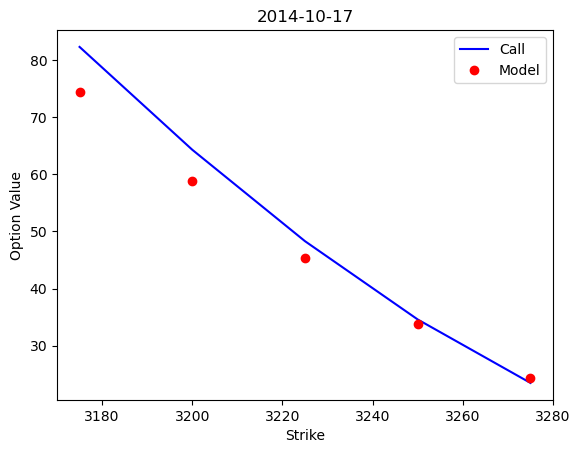

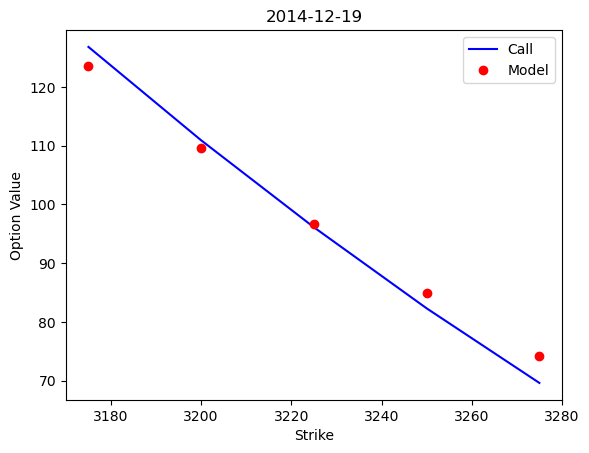

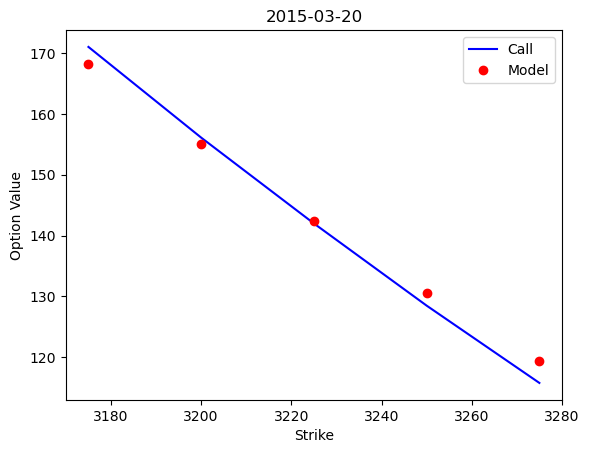

In [27]:
def generate_plot(opt, options):
    # First, we calculate model prices
    sigma, lamb, mu, delta = opt
    options["Model"] = 0.0
    for row, option in options.iterrows():
        options.loc[row, "Model"] = M76_call_value(
            S0, option["Strike"], option["T"], option["r"], sigma, lamb, mu, delta
        )

    # Second, we plot
    mats = sorted(set(options["Maturity"]))
    options = options.set_index("Strike")
    for i, mat in enumerate(mats):
        options[options["Maturity"] == mat][["Call", "Model"]].plot(
            style=["b-", "ro"], title="%s" % str(mat)[:10]
        )
        plt.ylabel("Option Value")

generate_plot(opt, options)

______________

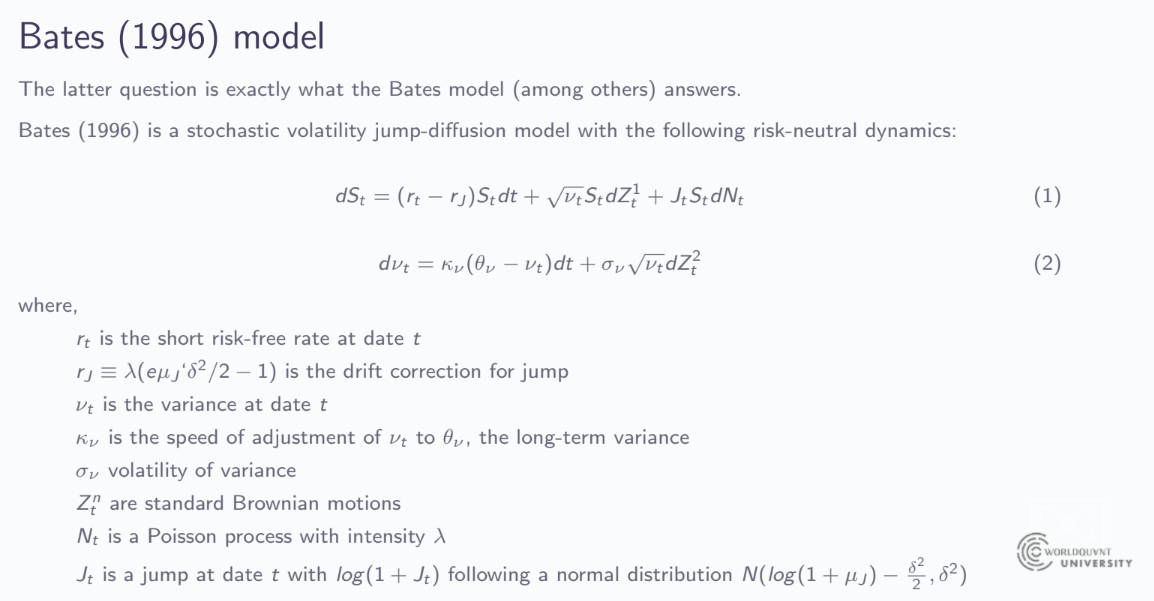

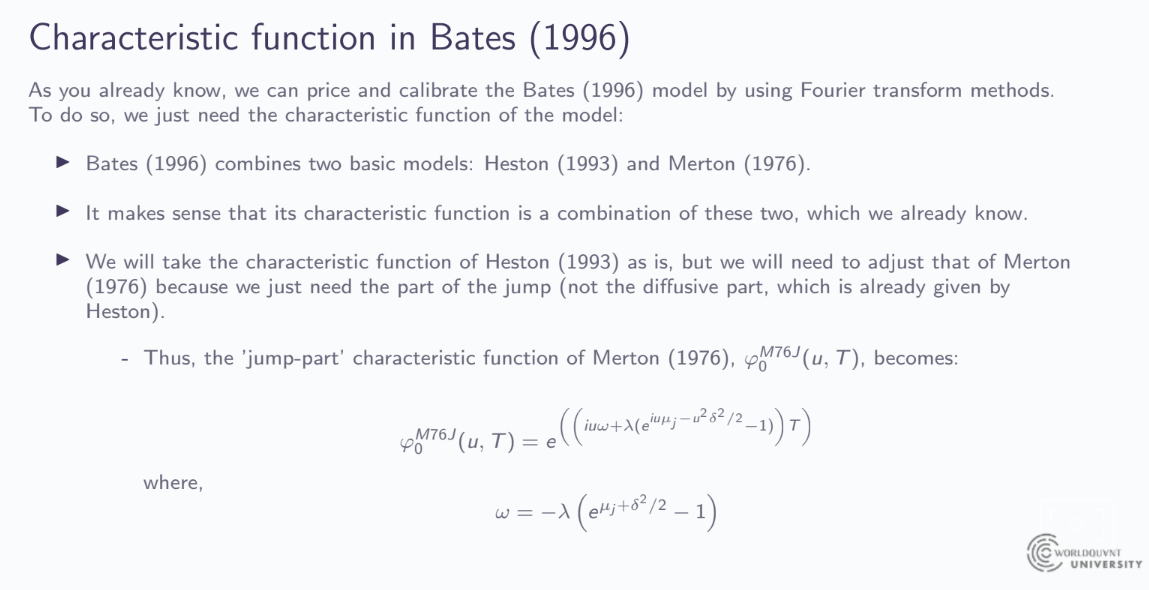

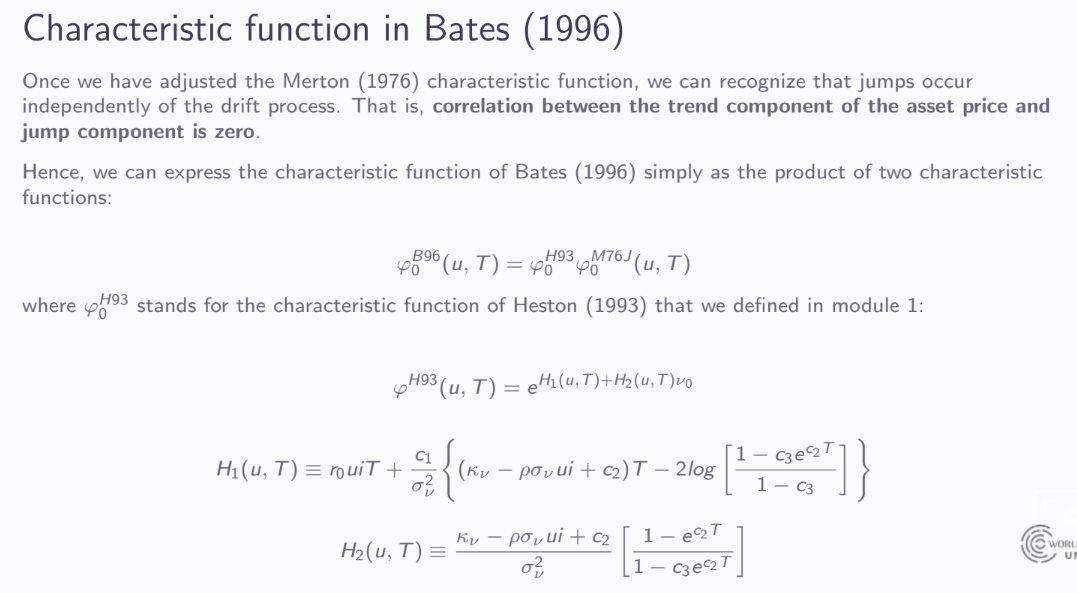

_____________

# **BATES (1996) IN PRACTICE** 

In [28]:
import numpy as np
from scipy.integrate import quad

## **1. Lewis (2001) Approach**

As we already know, the value of a call option under Lewis (2001) is determined by:

$$
\begin{equation*}
    C_0 = S_0 - \frac{\sqrt{S_0 K} e^{-rT}}{\pi} \int_{0}^{\infty} \mathbf{Re}[e^{izk} \varphi^{B96}(z-i/2)] \frac{dz}{z^2+1/4}
\end{equation*}
$$
where $\varphi^{B96}( )$ is the characteristic function of the model. In this case, the characteristic function of Bates (1996) was given by:

$$
\begin{equation*}
        \varphi^{B96}_0 (u, T) = \varphi^{H93}_0 \varphi^{M76J}_0 (u, T)
\end{equation*}
$$

which is essentially the product of two characteristic functions. Let's first define each of these characteristic functions:


### **1.1. Characteristic Functions** 

### **1.1.1. Heston (1993) Characteristic Function**

The characteristic function of Heston (1993), as we saw in Module 1, is given by:

$$
\
\begin{equation*}
  \varphi^{H93} (u, T) = e^{H_1(u, T)+H_2(u,T)\nu_0}
\end{equation*}
$$
\
where
$$
\
\begin{equation*}
  H_1 (u, T) \equiv r_0 uiT + \frac{c_1}{\sigma_\nu^2}\Biggl\{ (\kappa_\nu - \rho \sigma_\nu ui+c_2) T - 2 log \left[ \frac{1-c_3e^{c_2T}}{1-c_3} \right] \Biggl\}
\end{equation*}
$$
$$
\
\begin{equation*}
  H_2 (u, T) \equiv \frac{\kappa_\nu - \rho \sigma_\nu ui + c_2}{\sigma_\nu^2} \left[ \frac{1-e^{c_2T}}{1-c_3e^{c_2T}} \right]
\end{equation*}
$$
$$
\
\begin{equation*}
  c_1 \equiv \kappa_\nu \theta_\nu
\end{equation*}
$$
$$
\
\begin{equation*}
  c_2 \equiv - \sqrt{(\rho \sigma_\nu ui - \kappa_\nu)^2 - \sigma_\nu^2(-ui-u^2) }
\end{equation*}
$$
$$
\
\begin{equation*}
  c_3 \equiv \frac{\kappa_\nu - \rho \sigma_\nu ui + c_2}{\kappa_\nu - \rho \sigma_\nu ui - c_2}
\end{equation*}
$$

So let's first code this into a function to use later:


In [29]:
def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model via Lewis (2001)
    Fourier-based approach: characteristic function.
    Parameter definitions see function BCC_call_value."""
    c1 = kappa_v * theta_v
    c2 = -np.sqrt(
        (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2)
    )
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
        kappa_v - rho * sigma_v * u * 1j - c2
    )
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    H2 = (
        (kappa_v - rho * sigma_v * u * 1j + c2)
        / sigma_v**2
        * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    )
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

def M76J_char_func(u, T, lamb, mu, delta):
    """
    Adjusted Characteristic function for Merton '76 model: Only jump component
    """

    omega = -lamb * (np.exp(mu + 0.5 * delta**2) - 1)
    char_func_value = np.exp(
        (1j * u * omega + lamb * (np.exp(1j * u * mu - u**2 * delta**2 * 0.5) - 1))
        * T
    )
    return char_func_value

def B96_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Bates (1996) characteristic function
    """
    H93 = H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    M76J = M76J_char_func(u, T, lamb, mu, delta)
    return H93 * M76J

def B96_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Lewis (2001) integral value for Bates (1996) characteristic function
    """
    char_func_value = B96_char_func(
        u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
    )
    int_func_value = (
        1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    )
    return int_func_value

def B96_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Valuation of European call option in B96 Model via Lewis (2001)
    Parameters:
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        time-to-maturity (for t=0)
    r: float
        constant risk-free short rate
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial level of variance
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    ==========
    """
    int_value = quad(
        lambda u: B96_int_func(
            u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
        ),
        0,
        np.inf,
        limit=250,
    )[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value

In [30]:
S0 = 2247.5
K = 2250
T = 19 / 365
r = 0.025
kappa_v = 1.85
theta_v = 0.06
sigma_v = 0.45
rho = -0.75
v0 = 0.21
lamb = 0.13
mu = -0.4
delta = 0.3

print(
    "B96 Call option price via Lewis(2001): $%10.4f"
    % B96_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
)

B96 Call option price via Lewis(2001): $   94.0732



## **2. FFT Approach - Carr and Madan (1999)**

As an alternative to Lewis (2001), we could also implement the FFT algorithm. Essentially, we can apply FFT to the integral in the call option price derived by Carr and Madan (1999):
$$
\
\begin{equation*}
    C_0 = \frac{e^{-\alpha \kappa}}{\pi} \int_{0}^{\infty} e^{-i\nu \kappa} \frac{e^{-rT} \varphi^{B96} (\nu - (\alpha + 1)i, T)}{\alpha^2 + \alpha - \nu^2 + i(2\alpha + 1)\nu} d\nu
\end{equation*}
$$
\
Here we are going to use the same numerical routine we implemented in Module 1; please go there for more information. As was the case with the Lewis (2001) approach, we basically have to adapt the characteristic function we are considering to be the Bates (1996) one.

In [31]:
def B96_call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Call option price in Bates (1996) under FFT
    """

    k = np.log(K / S0)
    g = 1  # Factor to increase accuracy
    N = g * 4096
    eps = (g * 150) ** -1
    eta = 2 * np.pi / (N * eps)
    b = 0.5 * N * eps - k
    u = np.arange(1, N + 1, 1)
    vo = eta * (u - 1)

    # Modifications to ensure integrability
    if S0 >= 0.95 * K:  # ITM Case
        alpha = 1.5
        v = vo - (alpha + 1) * 1j
        modcharFunc = np.exp(-r * T) * (
            B96_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
            / (alpha**2 + alpha - vo**2 + 1j * (2 * alpha + 1) * vo)
        )

    else:
        alpha = 1.1
        v = (vo - 1j * alpha) - 1j
        modcharFunc1 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo - 1j * alpha))
            - np.exp(r * T) / (1j * (vo - 1j * alpha))
            - B96_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
            )
            / ((vo - 1j * alpha) ** 2 - 1j * (vo - 1j * alpha))
        )

        v = (vo + 1j * alpha) - 1j

        modcharFunc2 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo + 1j * alpha))
            - np.exp(r * T) / (1j * (vo + 1j * alpha))
            - B96_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
            )
            / ((vo + 1j * alpha) ** 2 - 1j * (vo + 1j * alpha))
        )

    # Numerical FFT Routine
    delt = np.zeros(N)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = (3 + (-1) ** j - delt) / 3
    if S0 >= 0.95 * K:
        FFTFunc = np.exp(1j * b * vo) * modcharFunc * eta * SimpsonW
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = np.exp(-alpha * k) / np.pi * payoff
    else:
        FFTFunc = (
            np.exp(1j * b * vo) * (modcharFunc1 - modcharFunc2) * 0.5 * eta * SimpsonW
        )
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = payoff / (np.sinh(alpha * k) * np.pi)

    pos = int((k + b) / eps)
    CallValue = CallValueM[pos] * S0

    return CallValue

# Sample parameters for ATM option
S0 = 100
K = 100
T = 1.0
r = 0.05
kappa_v = 2.0
theta_v = 0.04
sigma_v = 0.2
rho = -0.7
v0 = 0.04

print(
    "B96 Call option price via Carr-Madan: $%10.4f"
    % B96_call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
)

B96 Call option price via Carr-Madan: $   12.0926


In [32]:
import numpy as np

def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Characteristic function for the Heston model."""
    # Parameters for the characteristic function
    alpha = -u * u * 0.5 - u * 0.5j
    beta = kappa_v - rho * sigma_v * u * 1j
    gamma = sigma_v ** 2 / 2
    d = np.sqrt(beta ** 2 - 4 * alpha * gamma)
    rp = (beta + d) / (2 * gamma)
    rm = (beta - d) / (2 * gamma)
    g = rm / rp
    # Avoid division by zero and log of zero
    exp_dT = np.exp(-d * T)
    G = (1 - g * exp_dT) / (1 - g)
    # Characteristic function
    C = r * u * 1j * T + (kappa_v * theta_v) / (sigma_v ** 2) * (
        (beta - d) * T - 2 * np.log(G)
    )
    D = (beta - d) / (sigma_v ** 2) * ((1 - exp_dT) / (1 - g * exp_dT))
    char_func_value = np.exp(C + D * v0)
    return char_func_value

def H93_call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Call option price in Heston (1993) under FFT (Carr and Madan approach)"""
    k = np.log(K / S0)
    g = 1  # Factor to increase accuracy
    N = g * 4096
    eps = (g * 150) ** -1
    eta = 2 * np.pi / (N * eps)
    b = 0.5 * N * eps - k
    u = np.arange(1, N + 1, 1)
    vo = eta * (u - 1)

    # Modifications to ensure integrability
    if S0 >= 0.95 * K:  # In-the-money case
        alpha = 1.5
        v = vo - (alpha + 1) * 1j
        modcharFunc = np.exp(-r * T) * (
            H93_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0)
            / (alpha ** 2 + alpha - vo ** 2 + 1j * (2 * alpha + 1) * vo)
        )
    else:  # Out-of-the-money case
        alpha = 1.1
        v = vo - 1j * (alpha + 1)
        modcharFunc1 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo - 1j * alpha))
            - np.exp(r * T) / (1j * (vo - 1j * alpha))
            - H93_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0
            )
            / ((vo - 1j * alpha) ** 2 - 1j * (vo - 1j * alpha))
        )
        v = vo + 1j * (alpha - 1)
        modcharFunc2 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo + 1j * alpha))
            - np.exp(r * T) / (1j * (vo + 1j * alpha))
            - H93_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0
            )
            / ((vo + 1j * alpha) ** 2 - 1j * (vo + 1j * alpha))
        )

    # Numerical FFT Routine
    delt = np.zeros(N)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = (3 + (-1) ** j - delt) / 3
    if S0 >= 0.95 * K:
        FFTFunc = np.exp(1j * b * vo) * modcharFunc * eta * SimpsonW
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = np.exp(-alpha * k) / np.pi * payoff
    else:
        FFTFunc = (
            np.exp(1j * b * vo) * (modcharFunc1 - modcharFunc2) * 0.5 * eta * SimpsonW
        )
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = payoff / (np.sinh(alpha * k) * np.pi)

    pos = int((k + b) / eps)
    CallValue = CallValueM[pos] * S0

    return CallValue

# Sample parameters for ATM option
S0 = 100
K = 100
T = 1.0
r = 0.05
kappa_v = 2.0
theta_v = 0.04
sigma_v = 0.2
rho = -0.7
v0 = 0.04

# Calculate the call option price
call_price = H93_call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0)

print("H93 Call option price via Carr-Madan: $%10.4f" % call_price)

H93 Call option price via Carr-Madan: $   10.4610


_____________

## 1. Calibrate Heston (1993) stochastic volatility model

We already know that Bates (1996) model combines two desirable features: stochastic volatility of Heston (1993) and jump component from Merton (1976). Thus, as we know, the characteristic function, $\varphi^{B96}( )$, of Bates (1996) is given by:

$$
\
\begin{equation*}
        \varphi^{B96}_0 (u, T) = \varphi^{H93}_0 \varphi^{M76J}_0 (u, T)
\end{equation*}
$$

\
As we also know, $\varphi^{H93}_0$ stands for the characteristic function of Heston (1993). Thus, our first task in calibrating the Bates (1996) model will be to calibrate Heston (1993) model to observed market data. This is actually something we have already done before in Module 1 of the Stochastic Modeling course. Please, go there to revisit the calibration of Heston (1993) model to market prices of EuroStoxx 50 options. 

\
At this point, we assume that you know how to do the Heston calibration, so we will take advantage of the opportunity to introduce a python file format that some of you may be already familiar with, but that will come in handy in your data handling tasks: `.npy`

This is basically a Numpy format, you can check more about it here:
https://numpy.org/devdocs/reference/generated/numpy.lib.format.html

Now, the good thing about this file formatting is that it is extremely fast to read and load by python, so it can saves us a ton of time when we work with large numerical data sets. You can read more about its speed here:
https://www.kdnuggets.com/2018/04/start-using-npy-files-more-often.html

\
So, suppose that we have performed the calibration of Heston (1993) model and we have saved the parameters from stochastic volatility model in a `.npy` file using the `np.save( )` feature. We can simply load those parameters from the file (`opt_sv.npy`) now in order to perform our next task:

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import quad
from scipy.optimize import brute, fmin

In [34]:
# Option market data loading
h5 = pd.HDFStore("option_data_M2.h5", "r")
data = h5["data"]  # European call & put option data (3 maturities)
h5.close()
S0 = 3225.93  # EURO STOXX 50 level 30.09.2014

# Set tolerance level for near ATM options
tol = 0.02  # percent ITM/OTM options
options = data[(np.abs(data["Strike"] - S0) / S0) < tol]
options["Date"] = pd.DatetimeIndex(options["Date"])
options["Maturity"] = pd.DatetimeIndex(options["Maturity"])

# Adding Time-to-Maturity and constant short-rates
for row, option in options.iterrows():
    T = (option["Maturity"] - option["Date"]).days / 365.0
    options.loc[row, "T"] = T
    options.loc[row, "r"] = 0.02

# Select closest maturity
mats = sorted(set(options["Maturity"]))
options = options[options["Maturity"] == mats[0]]

time_to_mat = options["Maturity"].iloc[0] - options["Date"].iloc[0]

options.head(5)

C:\Users\Atakan\AppData\Local\Temp\ipykernel_10884\3974779713.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options["Date"] = pd.DatetimeIndex(options["Date"])
C:\Users\Atakan\AppData\Local\Temp\ipykernel_10884\3974779713.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options["Maturity"] = pd.DatetimeIndex(options["Maturity"])
C:\Users\Atakan\AppData\Local\Temp\ipykernel_10884\3974779713.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

,Date,Strike,Call,Maturity,Put,T,r
456,2014-09-30,3175.0,82.3,2014-10-17,24.5,0.046575,0.02
457,2014-09-30,3200.0,64.3,2014-10-17,31.5,0.046575,0.02
458,2014-09-30,3225.0,48.3,2014-10-17,40.5,0.046575,0.02
459,2014-09-30,3250.0,34.6,2014-10-17,51.8,0.046575,0.02
460,2014-09-30,3275.0,23.5,2014-10-17,65.8,0.046575,0.02


## 2.2. Problems in calibrating the jump component

Now, we have already calibrated a jump-diffusion model when we looked at Merton (1976) at the beginning of the module. At this point, we bring up a couple of drawbacks related to the calibration of these type of models. 

There are two basic flaws related to the calibration of jump diffusion (and other) type of models. Probably you have think of these by yourselves already:

- 1. Different combinations of parameter values may yield same (or very similar) values for the error function.

- 2. We may encounter many local minima in the error function, making it difficult for the algorithm to decide.

Overall, these two problems sum up to the fact that we can find very different parameters values when we come back to recalibrate our model. Thus the challenge of finding stable parameters in our calibrations. This is key in practice not only for pricing, but, more importantly, for hedging.

\
For more information on these, you can check, among others, the Galluccio and Le Cam (2008) paper freely available here:
https://papers.ssrn.com/sol3/papers.cfm?abstract_id=831784


## 2.3. Regularization of the error function

In order to try mitigate the aforementioned issues, a technique that practitioners usually implement is regularization of the error function. There are many way to do this in order to obtain more stable calibrated parameters. In here we will follow a classic: Tikhonov regularization (general info here: https://en.wikipedia.org/wiki/Tikhonov_regularization)

In our setting, Tikhonov regularization basically consists on imposing a **penalty term** to the local optimization error function. This penalty function will have the following form:

\
\begin{equation*}
    Penalty \ (p) \equiv \sqrt{(p_0 - p)^2}
\end{equation*}

\
with $p_0$ being the vector of initial parameter values and $p$ the current vector.

Thus, if we relied on a minimum squared error (MSE) function for our optimization, the regularized error function will be:

\
\begin{equation*}
    \min_p \frac{1}{N} \sum_{n=1}^{N} \left( C_n^* - C^{B96}_n(p) \right)^2 + ω \ Penalty (p)
\end{equation*}

\
where, as usual, $C_n^*$ is the option's market price, and $C^{B96}_n(p)$ stands for the model option price under parameter vector $p$. We can use $\omega$ to give more or less importance to the penalty.

Note that with this enhanced error function we are introducing a penalty for deviating from initial input values (that could come, for example, from previous calibrations of the model), so that the optimization process behaves in a more stable way, avoiding, unless strictly necessary, large difference in the parameters from initial values.


## 2.4. Calibration of the jump component

So, let's finally perform the calibration of the jump component. For that, we will proceed as usual, with a few minor twitches.

### 2.4.1. Error function

Let's start by setting calibration parameters and defining the error function, which obviously will be looking at differences between market and model prices for the complete Bates (1996) model:

In [35]:
i = 0
min_MSE = 5000.0
local_opt = False

def B96_error_function(p0):
    """
    Error function for Bates (1996) model

    Parameters:
    -------------
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    Returns
    -------------
    MSE: float
        mean squared error
    """

    global i, min_MSE, local_opt, opt1
    lamb, mu, delta = p0
    if lamb < 0.0 or mu < -0.6 or mu > 0.0 or delta < 0.0:
        return 5000.0
    se = []
    for row, option in options.iterrows():
        model_value = B96_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        se.append((model_value - option["Call"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    if local_opt:
        penalty = np.sqrt(np.sum((p0 - opt1) ** 2)) * 1
        return MSE + penalty
    return MSE

def B96_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Valuation of European call option in B96 Model via Lewis (2001)
    Parameters:
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        time-to-maturity (for t=0)
    r: float
        constant risk-free short rate
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial level of variance
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    ==========
    """
    int_value = quad(
        lambda u: B96_int_func(
            u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
        ),
        0,
        np.inf,
        limit=250,
    )[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value

def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model via Lewis (2001)
    Fourier-based approach: characteristic function.
    Parameter definitions see function BCC_call_value."""
    c1 = kappa_v * theta_v
    c2 = -np.sqrt(
        (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2)
    )
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
        kappa_v - rho * sigma_v * u * 1j - c2
    )
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    H2 = (
        (kappa_v - rho * sigma_v * u * 1j + c2)
        / sigma_v**2
        * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    )
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

def M76J_char_func(u, T, lamb, mu, delta):
    """
    Adjusted Characteristic function for Merton '76 model: Only jump component
    """

    omega = -lamb * (np.exp(mu + 0.5 * delta**2) - 1)
    char_func_value = np.exp(
        (1j * u * omega + lamb * (np.exp(1j * u * mu - u**2 * delta**2 * 0.5) - 1))
        * T
    )
    return char_func_value

def B96_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Bates (1996) characteristic function
    """
    H93 = H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    M76J = M76J_char_func(u, T, lamb, mu, delta)
    return H93 * M76J

def B96_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Lewis (2001) integral value for Bates (1996) characteristic function
    """
    char_func_value = B96_char_func(
        u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
    )
    int_func_value = (
        1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    )
    return int_func_value

def B96_calibration_short():
    """
    Calibrates jump component of Bates (1996) model to market prices
    """
    # First, we run with brute force
    # (scan sensible regions)
    opt1 = 0.0
    opt1 = brute(
        B96_error_function,
        (
            (0.0, 0.51, 0.1),  # lambda
            (-0.5, -0.11, 0.1),  # mu
            (0.0, 0.51, 0.25),
        ),  # delta
        finish=None,
    )

    # Second, we run with local, convex minimization
    # (dig deeper where promising)
    opt2 = fmin(
        B96_error_function,
        opt1,
        xtol=0.0000001,
        ftol=0.0000001,
        maxiter=550,
        maxfun=750,
    )
    return opt2

params = B96_calibration_short()

   0 | [ 0.  -0.5  0. ] |  80.696 |  80.696
  25 | [ 0.2  -0.5   0.25] | 205.873 |  80.696
  50 | [ 0.4 -0.5  0.5] | 447.506 |  80.696
  75 | [ 0.0e+00 -5.0e-01  2.5e-04] |  80.696 |  80.696
 100 | [ 7.45058060e-12 -5.08333333e-01  8.33333308e-05] |  80.696 |  80.696
 125 | [ 1.13686838e-16 -5.01041667e-01  1.04166667e-05] |  80.696 |  80.696
 150 | [ 8.88178420e-19 -5.00016276e-01  1.62760417e-07] |  80.696 |  80.696
 175 | [ 0.         -0.50000038  0.        ] |  80.696 |  80.696
Optimization terminated successfully.
         Current function value: 80.696463
         Iterations: 57
         Function evaluations: 170


In [36]:
params

array([ 0. , -0.5,  0. ])


## 3. Full Bates (1996) model calibration

For the final step of this lengthy calibration process, we can repeat the process of using the previously calibrated values as inputs for the full calibration of the model. 

In this case, our inputs will not only consist on the parameters from the stochastic volatility model ($\kappa_\nu$, $\theta_\nu$, $\sigma_\nu$, $\rho$, $\nu_0$), but also those from the jump component ($λ$, $\mu$, $\delta$).

Hence, our $p_0$ is defined as:

In [37]:
p0 = [kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta]

i = 0
min_MSE = 5000.0


def B96_full_error_function(p0):
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0

    if (
        kappa_v < 0.0
        or theta_v < 0.005
        or sigma_v < 0.0
        or rho < -1.0
        or rho > 1.0
        or v0 < 0.0
        or lamb < 0.0
        or mu < -0.6
        or mu > 0.0
        or delta < 0.0
    ):
        return 5000.0

    if 2 * kappa_v * theta_v < sigma_v**2:
        return 5000.0

    se = []
    for row, option in options.iterrows():
        model_value = B96_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        se.append((model_value - option["Call"]) ** 2)

    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

def B96_calibration_full():
    opt = fmin(
        B96_full_error_function, p0, xtol=0.001, ftol=0.001, maxiter=1250, maxfun=650
    )
    return opt

def B96_calculate_model_values(p0):
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0
    values = []
    for row, option in options.iterrows():
        model_value = B96_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )

        values.append(model_value)

    return np.array(values)

In [38]:
full_params = B96_calibration_full()
print(full_params)

   0 | [ 2.    0.04  0.2  -0.7   0.04  0.13 -0.4   0.3 ] | 140.937 | 140.937
  25 | [ 2.09215575  0.04068515  0.22224467 -0.70499254  0.02825538  0.12942989
 -0.41105409  0.33206628] |  17.306 |  17.306
  50 | [ 2.14315361  0.03956347  0.23185257 -0.74158903  0.02561059  0.12935206
 -0.41845425  0.31433456] |   5.585 |   2.337
  75 | [ 2.20114291  0.03988366  0.23928483 -0.7399814   0.02302904  0.12620958
 -0.42126357  0.32139711] |   2.273 |   2.267
 100 | [ 2.05613487  0.04018233  0.22497859 -0.6936426   0.02232623  0.14010817
 -0.47275094  0.3271676 ] |   1.954 |   1.940
 125 | [ 1.7948223   0.04024486  0.19689305 -0.61156154  0.02117152  0.16515162
 -0.55940472  0.34003038] |   1.364 |   1.171
 150 | [ 1.69935851  0.04032329  0.18729489 -0.58154903  0.02050831  0.17428045
 -0.59372892  0.34542214] |   1.110 |   1.079
 175 | [ 1.68194141  0.04043393  0.18704224 -0.57404254  0.02027553  0.17661035
 -0.59956353  0.34379325] |   1.041 |   1.041
 200 | [ 1.66964472  0.04063668  0.189202

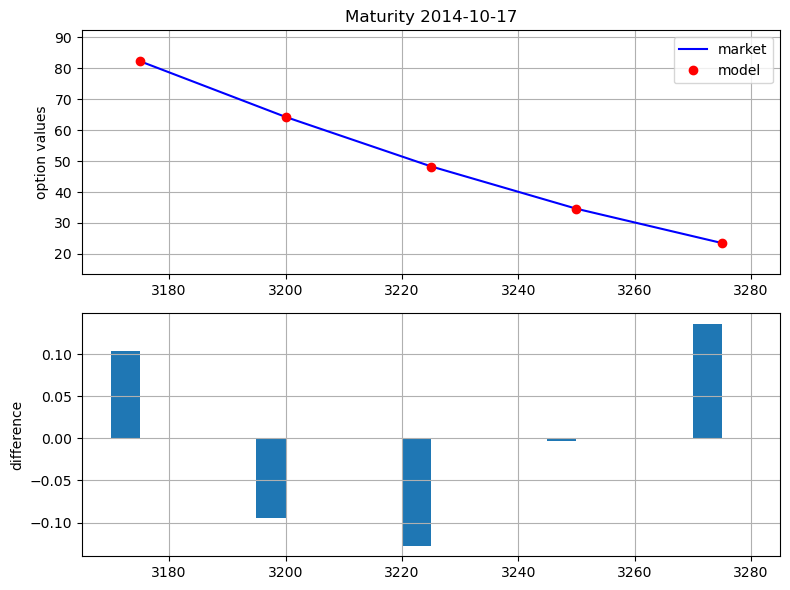

In [39]:
def plot_full_calibration_results(p0):
    options["Model"] = B96_calculate_model_values(p0)
    plt.figure(figsize=(8, 6))
    plt.subplot(211)
    plt.grid()
    plt.title("Maturity %s" % str(options["Maturity"].iloc[0])[:10])
    plt.ylabel("option values")
    plt.plot(options.Strike, options.Call, "b", label="market")
    plt.plot(options.Strike, options.Model, "ro", label="model")
    plt.legend(loc=0)
    plt.axis(
        [
            min(options.Strike) - 10,
            max(options.Strike) + 10,
            min(options.Call) - 10,
            max(options.Call) + 10,
        ]
    )
    plt.subplot(212)
    plt.grid()
    wi = 5.0
    diffs = options.Model.values - options.Call.values
    plt.bar(options.Strike.values - wi / 2, diffs, width=wi)
    plt.ylabel("difference")
    plt.axis(
        [
            min(options.Strike) - 10,
            max(options.Strike) + 10,
            min(diffs) * 1.1,
            max(diffs) * 1.1,
        ]
    )
    plt.tight_layout()

plot_full_calibration_results(full_params)